# Creating a classifier

Purpose: Train a classifier for identifying data science related projects. Determine given a project, what is the probability that it is data science?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#Prepare-dataset" data-toc-modified-id="Prepare-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare dataset</a></span></li><li><span><a href="#Define-models" data-toc-modified-id="Define-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define models</a></span></li><li><span><a href="#Train-and-evaluate-models" data-toc-modified-id="Train-and-evaluate-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train and evaluate models</a><span class="toc-item-num">&nbsp;&nbsp;</span></a></span></li></ul></li><li><span><a href="#Save-model-and-TFIDF-vectorizer" data-toc-modified-id="Save-model-and-TFIDF-vectorizer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save model and TFIDF vectorizer</a></span></li><li><span><a href="#Evaluate-selected-model-on-2019-RCDC-dataset" data-toc-modified-id="Evaluate-selected-model-on-2019-RCDC-dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluate selected model on 2019 RCDC dataset</a></span></li></ul></div>

In [8]:
import pandas as pd
import numpy as np
import sys, re, os, time, pickle
from datetime import datetime
import zipfile


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, PassiveAggressiveClassifier, SGDClassifier 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

# parameters for figure size
plt.rcParams['figure.figsize'] = [15, 10]

In [36]:
# folder for models 
model_folder = "./models/classifier"
# folder for results
results_folder = "./results/classifier"

##  Load dataset

In [10]:
# read in excel file of text and labels
# ann_df = pd.read_excel(os.path.join(data_folder,"all_annotations.xlsx"))
# oppen zipped dataset
with zipfile.ZipFile("full_data.zip") as z:
    with z.open("full_data.csv") as f:    
        ann_df = pd.read_csv(f)

In [11]:
ann_df = ann_df[["APPLICATION_ID", "PROJECT_TITLE", "ABSTRACT_TEXT", "DATA_SCIENCE"]]

ann_df.head()

,APPLICATION_ID,PROJECT_TITLE,ABSTRACT_TEXT,DATA_SCIENCE
0,9837480,Microglia mediated suppression of dopamine ind...,Project Summary The proposal's objective is to...,0.0
1,9864343,Cellular and Biochemical Pathways of Adipose M...,PROJECT SUMMARY/ABSTRACT There is a great deal...,0.0
2,9881316,DNA Nanostructures for High-Throughput Cryo-EM...,DNA Nanostructures for High-Throughput Cryo-EM...,0.0
3,9904588,Mouse Model of Human Papillomavirus Pathogenesis,Human papillomavirus (HPV) infections cause ap...,0.0
4,9923627,Delineating chromatin-related gene expression ...,"Summary Oral squamous cell carcinoma (OSCC), t...",0.0


In [12]:
# create column for abstract word count
ann_df["word_count"] = ann_df["ABSTRACT_TEXT"].str.split().str.len()

In [13]:
# stats on word_count
ann_df.word_count.describe()

count    78001.000000
mean       375.297971
std        106.226363
min          1.000000
25%        319.000000
50%        397.000000
75%        445.000000
max       3601.000000
Name: word_count, dtype: float64

In [14]:
# get total and count by class 
print("Number in negative class: " + str(len(ann_df[ann_df.DATA_SCIENCE==0])))
print("Number in positive class: " + str(len(ann_df[ann_df.DATA_SCIENCE==1])))
print("Total: " + str(len(ann_df)))

Number in negative class: 77943
Number in positive class: 195
Total: 78138


In [15]:
negative_class = ann_df[ann_df.DATA_SCIENCE==0]
negative_class = negative_class.iloc[0:199,]

positive_class = ann_df[ann_df.DATA_SCIENCE==1]

In [16]:
print("Number in negative class: " + str(len(negative_class)))
print("Number in positive class: " + str(len(positive_class)))

Number in negative class: 199
Number in positive class: 195


In [17]:
frames = [positive_class, negative_class]
ann_df = pd.concat(frames, sort=False)

In [18]:
ann_df.head()

,APPLICATION_ID,PROJECT_TITLE,ABSTRACT_TEXT,DATA_SCIENCE,word_count
547,9993273,Core A Computational Core,Core A: PROJECT SUMMARY The Computational Core...,1.0,154.0
563,9822171,Data Management Core: Systems Biology to Ident...,PROJECT SUMMARY The overarching goal of the pr...,1.0,370.0
1959,9828618,Developing Computational Methods for Surveilla...,PROJECT ABSTRACT Antimicrobial resistance is ...,1.0,371.0
2138,9861024,Statistical methods for correlated outcome and...,"Abstract (Shepherd and Shaw, R01, Statistical ...",1.0,357.0
3066,9933768,Resolving the bottleneck in antibiotic discovery,Abstract Most antibiotics resulted from the Wa...,1.0,396.0


In [19]:
# get total and count by class 
print("Number in negative class: " + str(len(ann_df[ann_df.DATA_SCIENCE==0])))
print("Number in positive class: " + str(len(ann_df[ann_df.DATA_SCIENCE==1])))
print("Total: " + str(len(ann_df)))

Number in negative class: 199
Number in positive class: 195
Total: 394


## Prepare dataset

The following code was taken from https://github.com/ncbi-nlp/VarTriage/blob/master/data_helpers.py

In [20]:
def clean_str(string):
    """
    Tokenization/string cleaning of text
    
    Original code from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`\-]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    #return string.strip().lower()
    return string.strip()

In [21]:
# concatenate title and abstract
ann_df["text"] = ann_df["PROJECT_TITLE"] + ". " + ann_df["ABSTRACT_TEXT"]

In [22]:
# clean text
ann_df["cleaned_text"] = ann_df["text"].apply(lambda x: clean_str(x))

In [23]:
# split data into training and testing sets

X = ann_df["cleaned_text"] 
y = ann_df["DATA_SCIENCE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

In [24]:
# generate a bag of words model based on the training set to vectorize the text

# instantiate the vectorizer object
tfidfvectorizer = TfidfVectorizer(analyzer="word", stop_words="english")

# tokenize and build vocab
tfidfvectorizer.fit(X_train)

# encode text
X_train = tfidfvectorizer.transform(X_train)
X_test  = tfidfvectorizer.transform(X_test)

## Define models

In [25]:
# initialize models

log_reg = LogisticRegression(solver="lbfgs")

# models used in LitSuggest 
ridge = RidgeClassifier(tol=1e-2, solver="sag", random_state=0)
perceptron = Perceptron(max_iter=100, tol=1e-3, random_state=0)
passive = PassiveAggressiveClassifier(max_iter=100, tol=1e-3, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
svc_l2 = LinearSVC(penalty="l2", dual=False, tol=1e-3, random_state=0)
svc_l1 = LinearSVC(penalty="l1", dual=False, tol=1e-3, random_state=0)
sgd_l2 = SGDClassifier(loss="log", alpha=.0001, max_iter=100, penalty="l2", tol=1e-3, random_state=0)
sgd_l1 = SGDClassifier(loss="log", alpha=.0001, max_iter=100, penalty="l1", tol=1e-3, random_state=0)
sgd_elastic = SGDClassifier(loss="log", alpha=.0001, max_iter=100, penalty="elasticnet", tol=1e-3, random_state=0)
multi_nb = MultinomialNB(alpha=.01)
bern_nb = BernoulliNB(alpha=.01)
comp_nb = ComplementNB(alpha=.1)   

# create dictionary of models

# initalize dictionary
models = dict()

# add models to dictionary
models["RidgeClassifier"] = ridge
models["Perceptron"] = perceptron
models["PassiveAggressiveClassifier"] = passive
models["KNeighborsClassifier"] = knn
models["LinearSVC with L2"] = svc_l2
models["LinearSVC with L1"] = svc_l1
models["SGDClassifier with L2"] = sgd_l2
models["SGDClassifier with L1"] = sgd_l1
models["SGDClassifier with Elastic Net"] = sgd_elastic
models["MultinomialNB"] = multi_nb
models["BernoulliNB"] = bern_nb
models["ComplementNB"] = comp_nb
models["Logistic Regression"] = log_reg

# create voting ensemble of models

# initialize list
ensemble_models = list()

# add models to list
ensemble_models.append(("RidgeClassifier", ridge))
ensemble_models.append(("Perceptron", perceptron))
ensemble_models.append(("PassiveAggressiveClassifier", passive))
ensemble_models.append(("KNeighborsClassifier", knn))
ensemble_models.append(("LinearSVC with L2", svc_l2))
ensemble_models.append(("LinearSVC with L1", svc_l1))
ensemble_models.append(("SGDClassifier with L2", sgd_l2))
ensemble_models.append(("SGDClassifier with L1", sgd_l1))
ensemble_models.append(("SGDClassifier with Elastic Net", sgd_elastic))
ensemble_models.append(("MultinomialNB", multi_nb))
ensemble_models.append(("BernoulliNB", bern_nb))
ensemble_models.append(("ComplementNB", comp_nb))
ensemble_models.append(("Logistic Regression", log_reg))

# define the voting ensemble
ensemble = VotingClassifier(estimators = ensemble_models, voting = "hard")
 
# add ensemble to list of models
models["Ensemble Majority Voting"] = ensemble

## Train and evaluate models

In [26]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y, score):
    """
    Evaluate model with repeated stratified k-fold cross validator.
    
    Input:  model 
            X - dataframe of features 
            y - dataframe of labels 
            score - string of scoring parameters (possible parameters listed here: 
            https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    
    Returns: scores
    """    
    # initialize repeated Stratified K-Fold cross validator
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    # calculate cross-validation scores
    scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1, error_score="raise")
    
    return scores

In [27]:
# evaluate the models and store results

# initialize lists to store results
results, results_binary, names = list(), list(), list()
accuracy_results, precision_results, recall_results, fscore_results = list(), list(), list(), list()

# iterate through each model
for name, model in models.items():
    
    # add name of model to names list
    names.append(name)
    
    # fit the model
    model.fit(X_train, y_train) 
    
    # predict on test set
    y_pred = model.predict(X_test)
    
    # get accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    
    # add to list
    accuracy_results.append(accuracy*100)
    
    # precision, recall, f1 by class
    clf_report = classification_report(y_test, y_pred)
    
    # precision, recall, f1 globally
    metric_report = precision_recall_fscore_support(y_test, y_pred, average = "macro")
    
    # add to lists
    precision_results.append(metric_report[0]*100)
    recall_results.append(metric_report[1]*100)
    fscore_results.append(metric_report[2]*100)
    
    # evaluate model with kfold cross-validation and scoring parameter accuracy
    accuracy_scores = evaluate_model(model, X_test, y_test, "accuracy")
    results.append(accuracy_scores)
    
    # evaluate model with kfold cross-validation and scoring parameter f1 
    f1_scores = evaluate_model(model, X_test, y_test, "f1")
    results_binary.append(f1_scores)
    
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

C:\Users\banwasia2\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


The accuracy of model RidgeClassifier is 0.92
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        47
         1.0       0.91      0.91      0.91        32

    accuracy                           0.92        79
   macro avg       0.92      0.92      0.92        79
weighted avg       0.92      0.92      0.92        79



The accuracy of model Perceptron is 0.89
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90        47
         1.0       0.81      0.94      0.87        32

    accuracy                           0.89        79
   macro avg       0.88      0.89      0.88        79
weighted avg       0.90      0.89      0.89        79



The accuracy of model PassiveAggressiveClassifier is 0.94
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        47
         1.0       0.91      0.94      0.92        32

    accuracy                     

C:\Users\banwasia2\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


The accuracy of model VotingClassifier is 0.92
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93        47
         1.0       0.88      0.94      0.91        32

    accuracy                           0.92        79
   macro avg       0.92      0.93      0.92        79
weighted avg       0.93      0.92      0.92        79





In [28]:
# transpose accuracy results from kfold cross-validation
cross_val_data = pd.DataFrame(data=results,index=names).transpose()

In [29]:
cross_val_data

,RidgeClassifier,Perceptron,PassiveAggressiveClassifier,KNeighborsClassifier,LinearSVC with L2,LinearSVC with L1,SGDClassifier with L2,SGDClassifier with L1,SGDClassifier with Elastic Net,MultinomialNB,BernoulliNB,ComplementNB,Logistic Regression,Ensemble Majority Voting
0,0.812500,0.937500,0.812500,0.625000,0.812500,0.687500,0.812500,0.812500,0.812500,0.750000,0.750000,0.750000,0.6875,0.812500
1,0.875000,0.875000,0.937500,0.812500,0.875000,0.687500,0.875000,0.937500,0.937500,0.812500,0.750000,0.937500,0.6875,0.875000
2,0.875000,0.687500,0.875000,0.875000,0.875000,0.812500,0.875000,0.812500,0.875000,1.000000,0.937500,1.000000,0.6250,0.875000
3,0.687500,0.812500,0.750000,0.875000,0.687500,0.625000,0.750000,0.750000,0.750000,0.750000,0.875000,0.812500,0.6250,0.750000
4,0.733333,0.866667,0.733333,0.800000,0.733333,0.666667,0.733333,0.733333,0.733333,0.866667,0.866667,0.866667,0.6000,0.733333
5,0.875000,0.875000,0.875000,0.750000,0.812500,0.687500,0.875000,0.875000,0.875000,0.937500,0.937500,1.000000,0.7500,0.875000
6,1.000000,1.000000,1.000000,0.937500,1.000000,0.812500,1.000000,1.000000,1.000000,1.000000,0.937500,1.000000,0.7500,1.000000
7,0.875000,0.875000,0.875000,0.750000,0.875000,0.875000,0.875000,0.937500,0.875000,0.750000,0.750000,0.875000,0.7500,0.875000
8,0.625000,0.750000,0.750000,0.687500,0.625000,0.562500,0.750000,0.750000,0.750000,0.687500,0.812500,0.750000,0.5625,0.750000
9,0.866667,0.933333,0.933333,0.866667,0.866667,0.600000,0.933333,0.866667,0.933333,0.933333,0.866667,0.933333,0.6000,0.933333


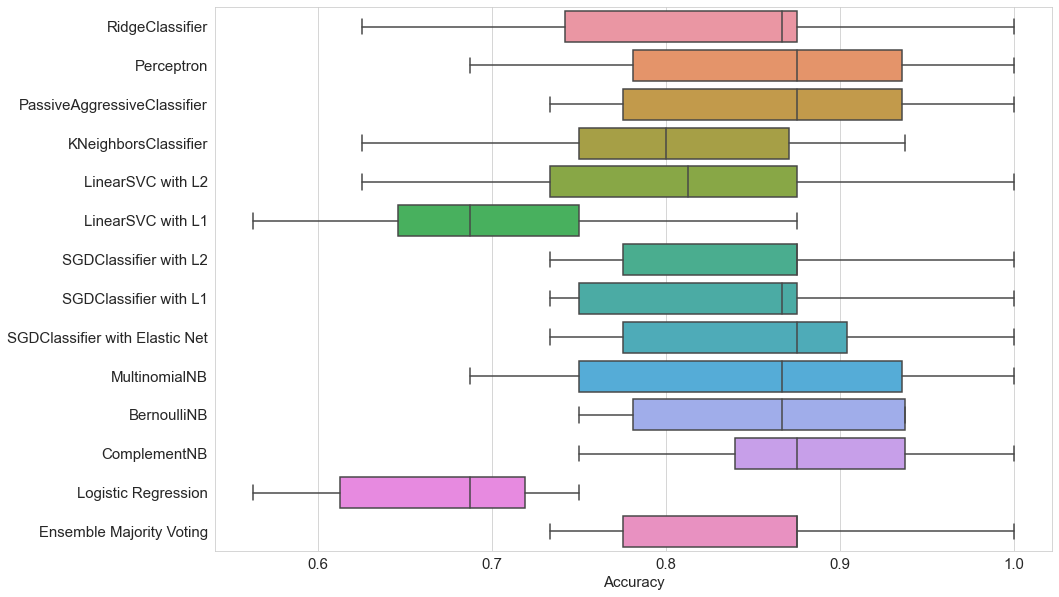

In [30]:
# plot results
sns.set_style("whitegrid")
ax = sns.boxplot(data=cross_val_data.iloc[:, :], orient="h")
ax.set_xlabel("Accuracy", fontsize=15)
ax.tick_params(labelsize=15)

In [31]:
# create dataframe of all results
eval_df = pd.DataFrame(list(zip(names, accuracy_results, precision_results, recall_results, fscore_results)), 
               columns =["Model", "Accuracy", "Precision", "Recall", "F1_Score"]) 

In [32]:
eval_df

,Model,Accuracy,Precision,Recall,F1_Score
0,RidgeClassifier,92.405063,92.121011,92.121011,92.121011
1,Perceptron,88.607595,88.159588,89.428191,88.422081
2,PassiveAggressiveClassifier,93.670886,93.280632,93.683511,93.465674
3,KNeighborsClassifier,77.215190,79.578393,79.853723,77.211538
4,LinearSVC with L2,92.405063,92.121011,92.121011,92.121011
5,LinearSVC with L1,84.810127,85.014006,83.244681,83.877551
6,SGDClassifier with L2,92.405063,91.895425,92.619681,92.193676
7,SGDClassifier with L1,91.139241,90.678524,91.057181,90.851944
8,SGDClassifier with Elastic Net,92.405063,91.895425,92.619681,92.193676
9,MultinomialNB,88.607595,88.493590,89.926862,88.489558


In [33]:
# save as excel file
eval_df.to_excel(os.path.join(results_folder,"eval_macro_scores.xlsx"))

FileNotFoundError: [Errno 2] No such file or directory: './results/classifier\\eval_macro_scores.xlsx'

## Save model and TFIDF vectorizer

In [37]:
# save model to file
model_filename = "ridge.pkl"
pickle.dump(ridge, open(os.path.join(model_folder, model_filename), "wb"))

# save tfidf to file
tfidf_filename = "tfidf.pkl"
pickle.dump(tfidfvectorizer, open(os.path.join(model_folder, tfidf_filename), "wb"))

## Evaluate selected model on 2019 RCDC dataset

In [43]:
# load the model and TFIDF vectorizer 
model_filename = "ridge.pkl"
tfidf_filename = "tfidf.pkl"

ridge_classifier = pickle.load(open(os.path.join(model_folder, model_filename), "rb"))
tfidfvectorizer = pickle.load(open(os.path.join(model_folder, tfidf_filename), "rb"))

In [39]:
# read in excel file of text and labels
# covid_df = pd.read_excel("covid_annotations_11102020.xlsx") 

with zipfile.ZipFile("2019_data.zip") as z:
    with z.open("2019_data.csv") as f:    
        df_2019 = pd.read_csv(f)

In [40]:
df_2019 = df_2019[["APPLICATION_ID", "PROJECT_TITLE", "ABSTRACT_TEXT", "DATA_SCIENCE"]]
df_2019

,APPLICATION_ID,PROJECT_TITLE,ABSTRACT_TEXT,DATA_SCIENCE
0,9846949,An Adaptive Strategy for Preventing and Treati...,Abstract This R34 application is best understo...,1.0
1,9634845,Consortium for Viral Systems Biology Data Mana...,Project Summary / Abstract� Our� Center� seeks...,1.0
2,9728261,"Data Management, Analysis and Resources Dissem...","SUMMARY. The Data Management, Analysis and Res...",1.0
3,9729349,"Data Management, Analysis, and Resources Disse...","Data Management, Analysis, and Resources Disse...",1.0
4,9671859,Data Sciences Core,Biostatistics/Biomedical Informatics ? PROJECT...,1.0
5,9764969,Biostatistics & Data Science Core,Core G: Biostatistics and Data Science ABSTRAC...,1.0
6,9695151,Leveraging Big Data to understand and improve ...,In the US only 30% of all HIV-infected (HIV+) ...,1.0
7,9607486,Data Management Core: Systems Biology to Ident...,PROJECT SUMMARY The overarching goal of the pr...,1.0
8,9674366,Data Management and Biostatistics Core,Data Management and Biostatistics Core SUMMARY...,1.0
9,9724345,Reproducible Analytics for Secondary Analyses ...,Project Summary The immunology database and an...,1.0


In [44]:
# concatenate title and abstract
df_2019["text"] = df_2019["PROJECT_TITLE"] + ". " + df_2019["ABSTRACT_TEXT"]
# clean text
df_2019["cleaned_text"] = df_2019["text"].apply(lambda x: clean_str(str(x)))
# encode text
X_test = tfidfvectorizer.transform(df_2019["cleaned_text"].values)
y_test = df_2019["DATA_SCIENCE"].values

In [45]:
# evaluate performance of model on testing set
score = ridge_classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.92


In [49]:
# get predicted labels for testing set
y_pred = ridge_classifier.predict(X_test)

# get probabilities
probabilities = ridge_classifier.decision_function(X_test)

# keep only the max probability for each publication
#max_probs = np.amax(probabilities, axis=1)

# calculate precision, recall, and fscore for positive class
precision_recall_fscore_support(y_test, y_pred, average="binary")

(0.8620689655172413, 1.0, 0.9259259259259259, None)

In [50]:
# generate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(21, 4, 0, 25)

In [52]:
pd.set_option("display.max_colwidth", None) # to view entire abstract in notebook

# create dataframe of true labels, predicted labels, and abstracts
labels = pd.DataFrame({"abstracts": df_2019["cleaned_text"],
                       "test": y_test, 
                       "pred": y_pred,
                       "probs": probabilities                      
                      })

# filter to just positive labels
positives = labels[(labels.test == 0) & (labels.pred == 1)]
positives

,abstracts,test,pred,probs
38,"COLLABORATIVE RESEARCH A MATHEMATICAL THEORY OF TRANSMISSIBLE VACCINES Viral vaccines have had remarkable and long-lasting impacts on human health , resulting in the world wide eradication of smallpox , the elimination of polio within much of the developed world , and the effective control of many other diseases Although great strides have been made in the development and production of vaccines since Edward Jenner 's first vaccinations with cowpox in the early 1800 's , little has changed in the way vaccines are delivered Even today , virtually every vaccine must be given directly to the patient Recent advances in molecular biology suggest that the centuries-old method of individual-based vaccine delivery could be on the cusp of a major revolution Specifically , genetic engineering brings to life the possibility of a transmissible vaccine Rather than directly vaccinating every individual within a population , a transmissible vaccine would allow large swaths of the population to be vaccinated effortlessly by releasing an infectious agent that is genetically engineered to be benign yet infectious In fact , some existing vaccines are transmissible to a limited extent , and transmissible vaccines have already been developed and deployed in wild animal populations Remarkably enough , however , no theory exists to guide the safe and effective use of this revolutionary new type of vaccine We will develop a mathematical framework for understanding the ecology and evolution of transmissible vaccines , and test the emerging mathematical results using an experimental viral system Epidemiological efficacy will be assessed by calculating the gains in disease protection conferred by a transmissible vaccine relative to a traditional vaccine Evolutionary robustness will be explored using models that predict the rate at which a genetically engineered vaccine will lose its efficacy or increase its virulence In both cases , models will be analyzed using a combination of direct and asymptotic solutions , approximations , numerical solutions , and individual-based simulations Key mathematical results will be tested experimentally using interactions between bacteria and viruses that infect them",0.0,1.0,0.148799
39,"BRAIN INITIATIVE RESOURCE DEVELOPMENT OF A HUMAN NEUROELECTROMAGNETIC DATA ARCHIVE AND TOOLS RESOURCE \( NEMAR \) To take advantage of recent and ongoing advances in intensive and large-scale computational methods , and to preserve the scientific data created by publicly funded research projects , data archives must be created as well as standards for specifying , identifying , and annotating deposited data The value of and interest in such archives among researchers can be greatly increased by adding to them an active computational capability and framework of analysis and search tools that support further analysis as well as larger scale meta-analysis and large scale data mining The OpenNeuro org archive , begun as a repository for functional magnetic resonance imaging \( fMRI \) data , is such an archive We propose to build a gateway to OpenNeuro for human electrophysiology data \( EEG and MEG , as well as intracranial data recorded from clinical patients to plan brain surgeries or other therapies \) \? herein we refer to these modalities as neuroelectromagnetic \( NEM \) data The Neuroelectromagnetic Data Archive and Tools Resource \( NEMAR \) at the San Diego Supercomputer Center will act as a gateway to OpenNeuro for NEM data research Such data uploaded to NEMAR at SDSC will be deposited in the OpenNeuro archive Still- private NEM data in OpenNeuro will , on user request , be copied to the NEMAR gateway for further user processing using the XSEDE high-performance resources at SDSC in conjunction with The Neuroscience Gateway \( nsgportal org \) , a freely available and easy to use portal to use of high-performance computing resources for neuroscience research Publicly available OpenNeuro NEM data will

In [54]:
labels

,abstracts,test,pred,probs
0,"An Adaptive Strategy for Preventing and Treating Lapses of Retention in Adult HIV Care II \( ADAPT-R II \) Abstract This R34 application is best understood in the context of both a NIH-funded sequential multiple assignment randomized trial \( SMART \) \? Adaptive Strategies to Prevent and Treat Lapses of Retention \( ADAPT-1 \) \? nearing completion and a future trial \( ADAPT-3 \) motivated by observations from the ADAPT-1 Retention in HIV treatment over long periods of time represents an archetypal complex public health problem and requires innovative solutions The diversity of intensities and types of barriers to engagement mean that no single intervention is needed by all nor will work for all in need For example , counseling could help a patient experiencing stigma , but will not help an individual who wants to come but cannot afford transportation To respond to this conundrum , we carried out a SMART \( ADAPT-1 \) to test a family of adaptive retention strategies By maintaining lower intensity interventions in those doing well , adaptive strategies optimize efficiency , while escalating in those not doing well enhances effectiveness In ADAPT-1 , we initially randomized patients to one of three lower intensity interventions \( standard of care \( SOC \) , SMS messages and a conditional cash transfer \) Only those who fail to be consistently retained are re-randomized to one of three more intensive interventions \( SOC outreach , SMS message with a conditional cash transfer , or a navigator \) Emerging ADAPT-1 results \( in forthcoming publications \) confirm our original hypothesis that pegging the retention intervention to patient behavior improves outcomes , the study also revealed additional opportunities to extend a \? precision public health \? paradigm Specifically , we observed that different patients \( based on sociodemographic , clinical and laboratory characteristics \) respond differentially to different adaptive retention strategies This observation begs a further hypothesis use of predictive analytics \( optimized with cutting-edge machine learning techniques \) to distribute each intervention \( e g , SOC , cash transfer , SMS \) to those patients most likely to respond to that intervention can achieve further gains in effectiveness and efficiency over any single sequenced retention strategy , even if strategy is itself already adaptive We plan a future R01 application to test a machine learning based distribution of retention interventions as compared to best single sequential adaptive interventions \( from ADAPT-1 \) To prepare for the novel trial , we propose this R34 , to \( 1 \) develop and test the information technology basis for delivering on-demand predictions to health care workers in the field , \( 2 \) refine the statistical foundations of machine learning ability to predict through simulations and \( 3 \) assess the fit of machine learning based recommendations in the organizational , policy and ethical context of health systems in Kenya",1.0,1.0,0.205707
1,"Consortium for Viral Systems Biology Data Management and Bioinformatics Core Project Summary Abstract Our Center seeks to use high-throughput pro \? ling technologies to develop predictive models of Lassa fever and Ebola virus disease at a systems biology level The success of this mission is dependent on the unique cohorts and innovative pro \? ling methods , the combination of which will result in a unique and powerful data set In this context , the overall mission of the Data Management and Bioinformatics Core \( DMBC \) is to ensure that the Center utilizes best practices for data provenance , analysis , management , and dissemination throughout the data lifecycle To accomplish this mission , we will promote the robust collection and analysis of the primary data , develop a framework for reproducible work \? ows that can be used across the Center , and maximize dissemination and reuse of Center-generated dat

In [53]:
# stats on probabilities
positives.probs.describe()

count    4.000000
mean     0.257197
std      0.158408
min      0.148799
25%      0.169291
50%      0.194202
75%      0.282108
max      0.491587
Name: probs, dtype: float64

In [14]:
# save notebook to HTML
!jupyter nbconvert --to html Classifier.ipynb

[NbConvertApp] Converting notebook Classifier.ipynb to html
[NbConvertApp] Writing 574408 bytes to Classifier.html
